## Data Loading and Augmentation Using Keras

- Build and test a custom data generator in Keras for efficient, on-the-fly loading, and preprocessing of image datasets.
- Use Keras's `image_dataset_from_directory` utility to load and preprocess datasets with optimized performance using the `tf.data` API.
- Apply image augmentation and performance optimizations such as `.map()`, `.cache()`, and `.prefetch()` to build high-throughout data pipelines.
- Compare custom and built-in Keras data loaders in terms of code complexity, flexibility, and runtime efficiency. 

We will use two Keras functions to build efficient, automated data pipelines: custom data generator and the in-built Keras utility.
1. **Custom data generator**: We will write a Python generator function to load, preprocess, and yield batches of data on-the-fly. 
2. **In-built Keras utility**: We will use the highly optimized `tf.keras.utils.image_dataset_from_directory` function, which is the standard, production-ready approach for most image classification tasks. 

We will compare these two methods to understand their trade-offs in terms of simplicity, features, and performance.

#### Step 1: Install required libraries

In [2]:
%%capture captured_output
%pip install numpy==1.26
%pip install matplotlib==3.9.2
%pip install skillsnetwork
%pip install tensorflow==2.19

  Using cached tensorflow-2.19.0-cp39-cp39-win_amd64.whl.metadata (4.1 kB)
Using cached tensorflow-2.19.0-cp39-cp39-win_amd64.whl (375.7 MB)


ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'c:\\Users\\sekai\\.conda\\envs\\GPU\\Lib\\site-packages\\tensorflow\\lite\\python\\lite_constants.py'
Consider using the `--user` option or check the permissions.



In [3]:
output_text = captured_output.stdout
lines = output_text.splitlines()
output_last_10_lines = '\n'.join(lines[-10:])
if "error" in output_last_10_lines.lower():
    print("Library installation failed!")
    print("--- Error Details ---")
    print(output_last_10_lines)
else:
    print("Library installation was successful, let's proceed ahead")

Library installation was successful, let's proceed ahead


#### Step 2: Import libraries / Configure the setup

In [5]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import skillsnetwork

In [7]:
# Define directories
base_dir = "./images_dataSAT_2/"

dir_non_agri = os.path.join(base_dir, 'class_0_non_agri')
dir_agri = os.path.join(base_dir, 'class_1_agri')

Create a list containing paths of all files for both folders.

In [ ]:
all_image_paths = []
all_labels = []

label_non_agri = 0
label_agri = 1

for fname in os.listdir(dir_non_agri):
    all_image_paths.append(os.path.join(dir_non_agri, fname))
    all_labels.append(label_non_agri)

for fname in os.listdir(dir_agri):
    all_image_paths.append(os.path.join(dir_agri, fname))
    all_labels.append(label_agri)


In [12]:
temp = list(zip(all_image_paths, all_labels))
np.random.shuffle(temp)
all_image_paths, all_labels = zip(*temp)

# Above is just how it goes.

print("First 10 paths and labels (after shuffling): ", list(zip(all_image_paths[:10], all_labels[:10])))

First 10 paths and labels (after shuffling):  [('./images_dataSAT_2/class_0_non_agri\\tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UPE_20250427T170513.SAFE_21181.jpg', 0), ('./images_dataSAT_2/class_0_non_agri\\tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_14482.jpg', 0), ('./images_dataSAT_2/class_1_agri\\tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UPE_20250427T170513.SAFE_10449.jpg', 1), ('./images_dataSAT_2/class_0_non_agri\\tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_13247.jpg', 0), ('./images_dataSAT_2/class_1_agri\\tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_1337.jpg', 1), ('./images_dataSAT_2/class_0_non_agri\\tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_1945.jpg', 0), ('./images_dataSAT_2/class_0_non_agri\\tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_2463.jpg', 0), ('./images_dataSAT_2/class_1_agri\\tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32U

##### What is custom data generator? 

A custom data generator function uses the `yield` keyword. Unlike a regular function that returns once and terminates, a generator can yield multiple values, pausing its state between each call. This "lazy evaluation" is the core principle behind memory-efficient sequential loading. For deep learning, this means we can create a generator that provides one batch of data, waits for model to train on it, and then resumes to provide the next batch, all without loading the entire dataset into RAM.

#### Step 3: Create the generator function

The `custom_data_generator` function builds an infinite Python generator that supplies mini-batches of images and labels to a Keras model during training. It accepts 4 arguments: `image_paths`, a list of file locations; `labels`, the corresponding class IDs; `batch_size`, the number of samples per update; and `target_size`, a tuple dictating each image's resize dimensions.

At the start of every epoch, in the code we create an index array equal to the dataset length, **shuffle it with NumPy**, and reorder both paths and labels identically, preserving their pairing while randomizing order. The outer `while True` loop keeps the generator alive for successive epochs. Inside, a `for` loop walks through the shuffled dataset in `batch_size` steps, slicing out `batch_paths` and `batch_labels`. For each path, `tf.keras.utils.load_img` reads the image and rescales it to `target_size`; `img_to_array` converts the PIL image to a float32 NumPy array. These arrays accumulate in `batch_images`.

After the inner loop finishes, the batch is transformed into a NumPy array and divided by 255.0, scaling the pixel values from 0-255 to 0-1, which speeds convergence and stabilizes gradients. Finally, the generator yields a tuple (`batch_images`, `batch_labels`). It supports easy augmentation and custom preprocessing.

In [14]:
def custom_data_generator(image_paths, labels, batch_size, target_size=(64,64)):
    num_samples = len(image_paths)
    while True:
        # Shuffle data at the beginnig of each epoch
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        shuffled_paths = np.array(image_paths)[indices]
        shuffled_labels = np.array(labels)[indices]

        # Generate batch data
        for offset in range(0, num_samples, batch_size):
            batch_paths = shuffled_paths[offset:offset+batch_size]
            batch_labels = shuffled_labels[offset:offset+batch_size]

            # Load and preprocess images form the batch
            batch_images = []
            for path in batch_paths:
                img = tf.keras.utils.load_img(path, target_size=target_size)
                img_array = tf.keras.utils.img_to_array(img)
                batch_images.append(img_array)

            # Normalize and yield the batch data
            yield np.array(batch_images) / 255.0, np.array(batch_labels)

#### Step 4: Test and visualize the custom generator

Before feeding a generator to a model, it is essential to test it. First we instantiate `custom_data_generator` using `image_paths`, `labels` and `batch_size`, defining the key dataloading hyperparameters.

Next we will use `next(my_generator)` to get a batch of data. By calling `next(my_generator)`, we are asking the generator to execute its code until it hits the `yield` statement and to return the yielded values. This allows us to inspect a single batch to verify its shape, data types, and content. Visualizing the images with their corresponding labels, using tools like `matplotlib.pyploy.imshow`, provides a sanity check to ensure that the loading, preprocessing, and labeling logic is correct. we can display the images in two rows and 4 columns using `ax = plt.subplot(2, 4, i + 1)` code. This ensures optimal use of resources for displaying a sample batch of images with their labels.

Images batch shape: (8, 64, 64, 3)
Labels batch shape: (8,)


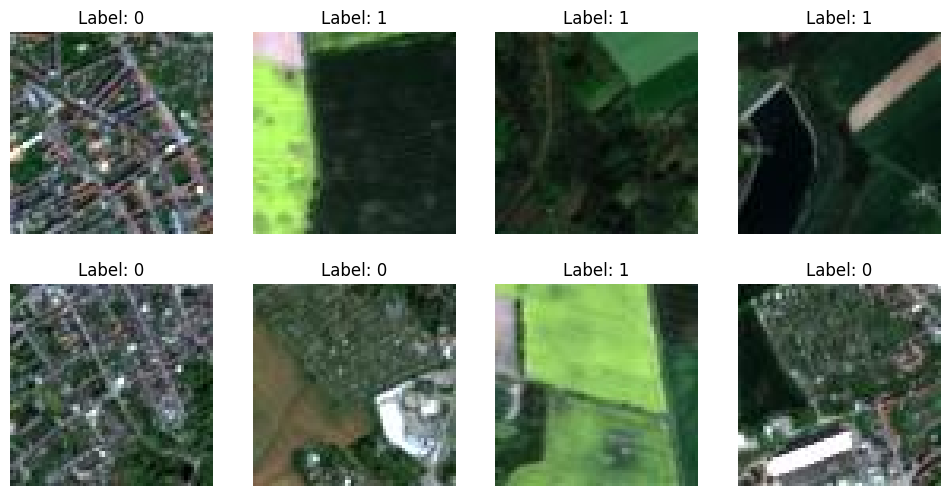

In [16]:
batch_size = 8
data_generator = custom_data_generator(image_paths=all_image_paths, labels=all_labels, batch_size=batch_size)

images, labels = next(data_generator)

print(f"Images batch shape: {images.shape}")
print(f"Labels batch shape: {labels.shape}")

plt.figure(figsize=(12,6))
for i in range(batch_size):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis("off")

##### What about Keras' built-in utility?


Now, instead of using a custom written data generator function, let us see how the `tf.keras.utils,image_dataset_from_directory` function works. This function is built on top of the highly efficient `tf.keras` library, which is TensorFlow's native solution for creating complex and performant input pipelines. This function automatically infers class labels from a standarized directory structure (e.g., `main_dir/class_a/`, `main_dir/class_b`) and returns a `tf.data.Dataset` object. This object is extremely memory efficient and gives the symbolic representation of a data stream, which can be manipulated and optimized for maximum performance.

#### Step 5: Create the training data

Use the `tf.keras.utils.image_dataset_from_directory` function with image size 64 x 64 pixels and a batch size of 8. 

In [18]:
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 8

train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels = "inferred",     # Labels are generated from directory structure
    label_mode = "int",      # Labels are endoed as integers (0, 1, ...)
    validation_split = 0.2,  # Reserve 20% of images for validaiton
    subset = 'training',     # This is the training set
    seed = 1337,             # Shuffle seed for reproducible splits
    image_size = IMAGE_SIZE, 
    batch_size = BATCH_SIZE
)

Found 6000 files belonging to 2 classes.
Using 4800 files for training.


In [21]:
validation_data = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels="inferred",
    label_mode = "int",
    validation_split = 0.2,
    subset = "validation",
    seed = 1337,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
)

Found 6000 files belonging to 2 classes.
Using 1200 files for validation.


#### Step 6: Explore the `tf.data.Dataset` object

The `tf.data.Dataset` object is a core component of TensorFlow's data input pipeline. It represents a sequence of elements, where each element is a tuple of (images, labels). It is designed for high-throughput, parallel processing. The `.take(1)` method is used here to fetch a single element (one batch) from this data stream for inspection. Unlike our custom generator, which loaded images as NumPy arrays, this utility loads them as TensorFlow Tensors, which is the native data type for tensorFlow operations. 

Class names inferred by Keras: ['class_0_non_agri', 'class_1_agri']


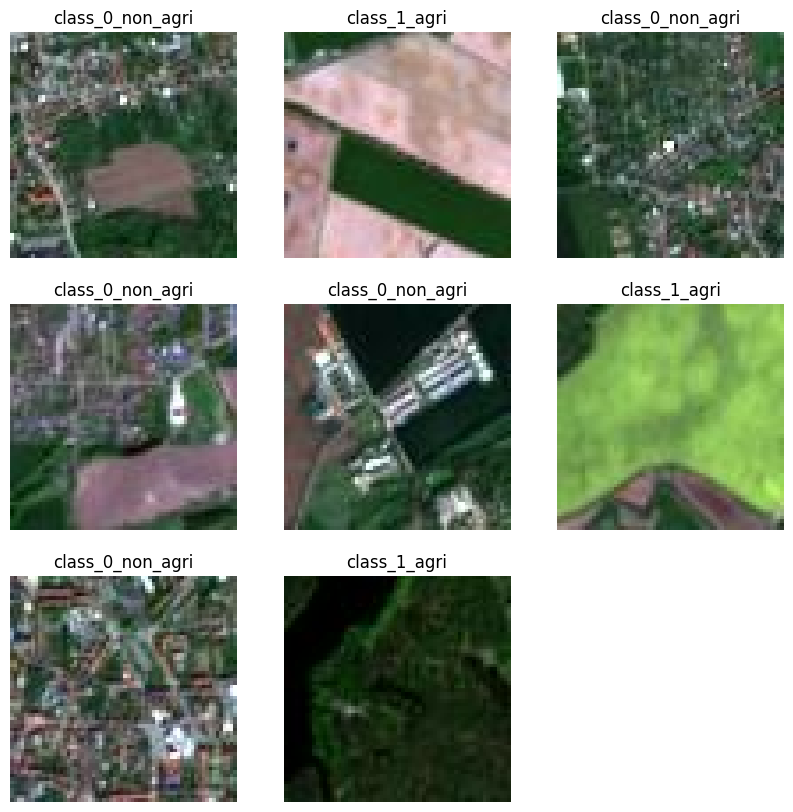

In [23]:
print(f"Class names inferred by Keras: {train_ds.class_names}")

# Let us visualize one batch from the training dataset
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1): # Take on batch
    for i in range(BATCH_SIZE):
        ax = plt.subplot(3, 3, i + 1)
        # Images are loaded as float 32, so we convert to uint 8 for display
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

#### Step 7: Configure the dataset for performance

The dedicated utility, `tf.data.Dataset`, can be chained with various methods to create a highly performant pipeline. 

- `map(function)`: Applies a given function to every element of the datatset. Here, it is used to apply data agumentation layers. Tensorflow can automatically parallelize this operation. 
- `.cache()`: Caches the dataset in memory after it's loaded from disk during the first epoch. For subsequent epochs, data will be read from the faster memory cache, significantly speeding up training. This is **only feasible if** the dataset fits in RAM.
- `.prefetch(buffer_size)`: It allows the data preprocessing (done on the CPU(?)) to happen in parallel with the model training (doneon GPU(?)). While the GPU is busy with the current batch, the CPU is already preparing the next batch. This overlapping of tasks prevents the GPU from sitting idle and waiting for data, a phenomenon known as an I/O bottleneck.
- `AUTOTUNE` lets TensorFlow dynamically decide the optimal buffer size for our computer.


In [ ]:
# This is the new/modern method.
# The ImageDataGenerator method is no longer recommended

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

# Apply augmentation to the training dataset using map
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Configure for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

print("Dataste is now configured for high performance")


Dataste is now configured for high performance


#### Comparison and analysis

We have seen two ways to create a data loader in Keras. This comparison highlights the engineering trade-offs between control and convenience.

| Feature                  | Custom data generator                                       | In-built Keras utility (`image_dataset_from_directory`)     |
|--------------------------|-------------------------------------------------------------|-------------------------------------------------------------|
| **Ease of use**          | Low. Requires significant boilerplate code for loops, shuffling, and batching. | High. A single, intuitive function call handles everything. |
| **Code complexity**      | High. You manually manage file paths, labels, loading, and preprocessing. | Low. The function abstracts away all the complexity.          |
| **Flexibility**          | Very high. You can implement any custom logic for loading or non-standard data structures. | Moderate. Designed for a standard directory structure (`class/images`), but very flexible within that. |
| **Features**             | Basic. Shuffling, augmentation, and validation splits must be coded manually. | Rich. Built-in shuffling, batching, and validation splits. Seamless integration with Keras preprocessing layers. |
| **Performance**          | Poor to moderate. A simple Python generator can become an I/O bottleneck for the GPU due to its single-threaded nature. | Excellent. Creates a `tf.data.Dataset` object, which is highly optimized and can be configured with `.cache()` and `.prefetch()` for maximum throughput. |
| **Recommended for**      | Learning purposes or highly specialized, non-standard datasets (e.g., loading from a database or a custom binary format). | **Almost all standard image classification tasks.**         |
